# 2nd Stage Panel Data Cleaning

This notebook loads in the first stage cleaned csv file and adds criteria for dropping certain observations from the data. Drop criteria may want to be adjusted in future revisions, this is why this notebook has been formally separated from the first stage file. Some preliminary visualizations of the data are also included.

# Import and Setup Universal Directory

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import operator # This allows one to pass operators into a Python function
import matplotlib.pyplot as plt # For graphics

In [2]:
# Universal directory setup
cwd1 = os.getcwd() 

# Go up one directory level
os.chdir('..')
cwd2 = os.getcwd()

# Make sure repository has a 2. Clean data and Saved data folders!
csv_path = cwd2 + '/2. Clean data/'
csv_save_path = cwd2 + '/Saved data/'

In [3]:
# Load in first stage cleaned data. Need to save 1st Stage Clean data in the same folder as this Notebook!
os.chdir(csv_path) 
dateCols =['last_scraped', 'host_since', 'first_review', 'last_review', 'scrape_batch']
df = pd.read_csv('1stStageClean_Portland.csv.gz', low_memory=False, compression='gzip', parse_dates=dateCols)
df.head(5)

,id,month,List_month,last_scraped,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,...,fixed_lag,NOR_diff,host_is_superhost_dum,room_type_dum,instant_bookable_dum,zipcode_dum,avg_lat,avg_lon,neighbourhood_dum,days_since_calup
0,7893,0,0,NaT,21489.0,Jesse,2009-06-14,US,NaN,NaN,...,NaN,NaN,-1,0,0,23,45.575479,-122.666777,62,NaN
1,7893,1,0,NaT,21489.0,Jesse,2009-06-14,US,NaN,NaN,...,NaN,NaN,-1,0,0,23,45.575479,-122.666777,62,NaN
2,7893,2,0,NaT,21489.0,Jesse,2009-06-14,US,NaN,NaN,...,NaN,NaN,-1,0,0,23,45.575479,-122.666777,62,NaN
3,7893,3,1,2016-01-01,21489.0,Jesse,2009-06-14,US,NaN,NaN,...,NaN,NaN,0,0,0,23,45.575479,-122.666777,62,21.0
4,7893,4,0,NaT,21489.0,Jesse,2009-06-14,US,NaN,NaN,...,2.0,NaN,-1,0,0,23,45.575479,-122.666777,62,NaN


--------------------

# Cleaning Part 2

In [4]:
def create_lagsleads(var, lag_range, df, title):
    """
    This function creates lag and lead variables for a given variable and dataframe.    
    """
    df = df.sort_values(by = ['id', 'month'])
    
    for i in range(-lag_range, lag_range + 1):
        
        if i == 0:
            continue
        
        if i < 0:
            df.loc[:, title + "lead" + str(abs(i)) ] = df.groupby('id')[var].shift(i)
                
        if i > 0: 
            df.loc[:, title + "lag" + str(abs(i)) ] = df.groupby('id')[var].shift(i)
            
    return df

In [5]:
Confidence_cutoff = 1.960 
df.loc[:, 'corrected_NOR'] = df.groupby(['id'])['number_of_reviews'].rolling(19, min_periods=1).max().reset_index(level=0, drop=True)
df = create_lagsleads('corrected_NOR', 12, df, "NOR") 
df.loc[:, "NOR_diff"] = df['corrected_NOR'] - df['NORlag1']
bounds = df.groupby('id')['NOR_diff'].mean() + Confidence_cutoff*df.groupby('id')['NOR_diff'].std()/np.sqrt(df.groupby('id')['List_month'].sum())
df.loc[:, "NOR_diff_bound"] = bounds[df['id']].values

In [6]:
def timedelta_formatter(var):
    """
    This function formats the time delta for a passed variable.
    """
    df.loc[:, var] = pd.to_timedelta(df[var]).dt.days
    
for deltas in ['days_since_rev', 'days_since_first_rev', 'host_length']:
    timedelta_formatter(deltas)

In [7]:
def test_var_change(var, cutoff, relate, df):
    """
    This function lists ids where the variable of interest changes ("var").
    """
    ops = {'>': operator.gt,
       '<': operator.lt,
       '>=': operator.ge,
       '<=': operator.le,
       '==': operator.eq}
    
    # Take ids and variable of interest and drop any na's
    repetition_arr = np.array(df[['id', var]].dropna().drop_duplicates()) # Need drop_duplicates to identify actual price changes
    counts = np.unique(repetition_arr[:,0], return_counts = True)
    return counts[0][ops[relate](counts[1], cutoff)], counts[1][ops[relate](counts[1], cutoff)]

In [8]:
# Store the ids for which the property type changes at least twice
change_ids, change_counts = test_var_change('property_type', 2, '>=', df)

In [9]:
# This gives the location of the first month hosted
first_host_ind = df.groupby('id').List_month.idxmax()
df.loc[:, "first_appearance"] = (df.index == first_host_ind[df['id']]).astype(float)

In [10]:
# This gives the last month hosted
df_list = df[df['List_month'] == 1]
last = df_list.groupby('id')['month'].last()

df.loc[:, 'last_app'] = (df['month'].values == last[df['id']].values).astype(float)

In [11]:
# Calculate cumulative listings for a given host
host_cumlists = df.groupby(['host_id', 'month'])['first_appearance'].sum().unstack().cumsum(axis=1).stack().astype(int)
host_cumlists.name = 'cum_sum'
df = df.join(host_cumlists, on=['host_id', 'month'], rsuffix='_cumsum')

# --- Calculate other summary statistics about host holdings ---

# Host listings per month
df = df.join(df.groupby(['host_id', 'month'])['List_month'].sum(), on=['host_id', 'month'], rsuffix='_byhost_month')

# Host overall listings over the dataset
df = df.join(df.groupby(['host_id'])['List_month'].sum(), on=['host_id'], rsuffix='_host_overall')

# Total times a given property is listed
df = df.join(df.groupby(['id'])['List_month'].sum(), on=['id'], rsuffix='_id_overall')

In [12]:
# Identify hotels in my data
df.loc[:, 'hotel_dum'] = np.array((df['property_type'] == "Boutique hotel") |
                                  (df['property_type'] == "Bed and breakfast") | 
                                  (df['property_type'] == "Boutique hotel") | 
                                  (df['property_type'] == "Aparthotel")| 
                                  (df['property_type'] == "Hotel")| 
                                  (df['property_type'] == "Resort")| 
                                  (df['property_type'] == "Serviced apartment") )*1

In [13]:
# Create a preliminary measure for an entrant Airbnb listing.
df.loc[:,"entrant"] =  np.array((df['first_appearance'] == 1) &
                                (df['days_since_first_rev'] < 30 ) & 
                                (df['number_of_reviews'] < 10 ))*1

In [14]:
# CALCULATE LISTINGS PER NEIGHBORHOOD

# Calculate the number of listings in a neighborhood on the Airbnb platform for a given month
df = df.join(df.groupby(['neighbourhood', 'month'])['List_month'].sum(), 
             on=['neighbourhood', 'month'], rsuffix='_byneigh')

# Calculate the lagged number of listings in a neighborhood on the Airbnb platform for a given month
df = df.join(df.sort_values(by=['neighbourhood', 'month']).groupby(['neighbourhood', 'month'])['List_month'].sum().shift(1), 
             on=['neighbourhood', 'month'], rsuffix='_lag_byneigh')

df.loc[:,'List_month_lag_byneigh'] =  df['List_month_lag_byneigh'].mask(df['month'] == 3, np.nan)

df.sort_values(by=['neighbourhood', 'month'])[['id', 'month', 'neighbourhood', 'List_month_byneigh', 'List_month_lag_byneigh']]

,id,month,neighbourhood,List_month_byneigh,List_month_lag_byneigh
11359,681972,0,Alameda,15,NaN
19388,1125125,0,Alameda,15,NaN
19425,1128026,0,Alameda,15,NaN
22496,1268272,0,Alameda,15,NaN
24827,1420478,0,Alameda,15,NaN
...,...,...,...,...,...
406518,29884092,36,Woodstock,93,90.0
407628,30010653,36,Woodstock,93,90.0
408294,30085303,36,Woodstock,93,90.0
413104,31043503,36,Woodstock,93,90.0


------

# 2. Drop Indicators 

### No reviews


In [15]:
df.loc[:, 'drop_indicator'] = 0

max_NORdiff = df.groupby('id')['NOR_diff'].max()
df.loc[:, 'max_NORdiff'] = max_NORdiff[df['id']].values

no_revs_ind = (df['max_NORdiff'] == 0).values*1
df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: no_revs_ind})

df['drop_indicator'].sum()

92722

### Extremely low or high prices

In [16]:
price_1per = df.price.quantile(.01)
price_99per = df.price.quantile(.99)

low_price = (df.groupby('id')['price'].min()[df['id']].values < price_1per)*1
high_price = (df.groupby('id')['price'].min()[df['id']].values > price_99per)*1

df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: low_price})
df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: high_price})

df['drop_indicator'].sum()

100270

### Never state a day of availability 

In [17]:
never_avail = (df.groupby('id')['availability_365'].max()[df['id']].values == 0)*1
df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: never_avail})

df['drop_indicator'].sum()

101491

### Minimum nights

In [18]:
long_term_rental = (df.groupby(['id'])['minimum_nights'].min()[df['id']].values > 30)*1
df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: long_term_rental})
df['drop_indicator'].sum()

102194

### Hotel indicator

In [19]:
hotel_ind = (df.groupby(['id'])['hotel_dum'].max()[df['id']].values == 1)*1
df.loc[:, 'drop_indicator'] = df['drop_indicator'].replace({ 0: hotel_ind})

df['drop_indicator'].sum()

107337

In [20]:
print(len(df[df['drop_indicator'] == 1]))
print(len(df[df['drop_indicator'] == 0]))

107337
311022


# 3. Save CSV

In [21]:
os.chdir(csv_save_path)

In [22]:
df.to_csv('2ndStageClean_Portland.csv.gz', compression='gzip', index=False, date_format='%Y-%m-%d %H:%M:%S')

--------
# Preliminary visualizations

## Visualizing the raw number of listings in the data
Below we present a visualization of the raw number of Airbnb listings in Portland before any listings have been dropped.

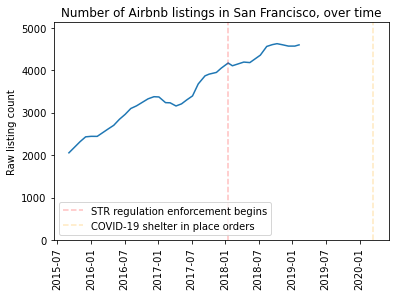

In [23]:
# Listing visualization

dates = df[df['drop_indicator'] ==0].groupby('scrape_batch')['List_month'].sum().index
counts = df[df['drop_indicator'] ==0].groupby('scrape_batch')['List_month'].sum().values

count_max = counts.max()
count_min = counts.min()
count_std = counts.std()

plt.plot(dates, counts)
plt.ylim(0, count_max + 500)
plt.xticks(rotation="vertical")
plt.axvline(datetime.datetime(2018, 1, 16, 0, 0), alpha=0.25, color='red', linestyle='--', label='STR regulation enforcement begins')
plt.axvline(datetime.datetime(2020, 3, 16, 0, 0), alpha=0.25, color='orange', linestyle='--', label='COVID-19 shelter in place orders')
plt.ylabel("Raw listing count")
plt.title("Number of Airbnb listings in Portland, over time")
plt.legend()

plt.show()

## Visualizing when new unique listings show up in the data.

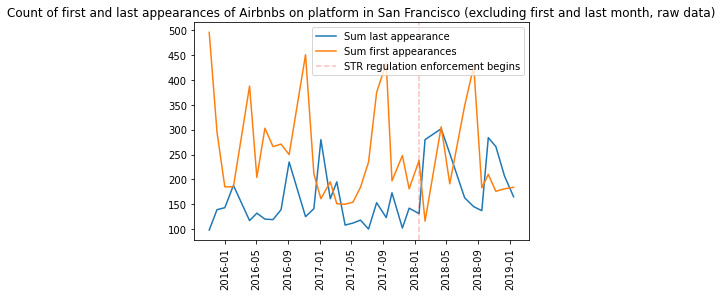

In [24]:
plt.plot(df.groupby('scrape_batch')['last_app'].sum()[1:-1], label='Sum last appearance')
plt.plot(df.groupby('scrape_batch')['first_appearance'].sum()[1:-1], label='Sum first appearances')
plt.title('Count of first and last appearances of Airbnbs on platform in Portland (excluding first and last month, raw data)')
plt.xticks(rotation="vertical")
plt.axvline(datetime.datetime(2018, 1, 16, 0, 0), alpha=0.25, color='red', linestyle='--', label='STR regulation enforcement begins')
plt.legend()
plt.show()

## Visualizing of total hotels listing on Airbnb

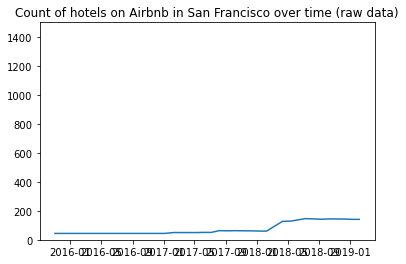

In [25]:
plt.plot(df.groupby('scrape_batch')['hotel_dum'].sum()[1:])
plt.title("Count of hotels on Airbnb in Portland over time (raw data)")
plt.ylim(0, 1500)
plt.show()

## Visualization of "entrant" Airbnb listings
My criteria for an "entrant" listing are:
* First time listing is ever seen in the data 
* Days since first review is less than 30 days
* Number of total reviews is less than 10

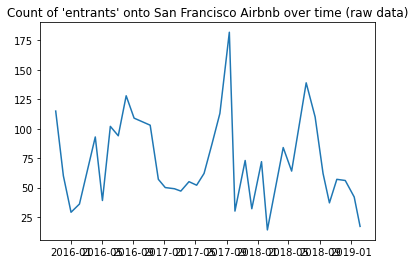

In [26]:
plt.plot(df.groupby('scrape_batch')['entrant'].sum()[1:])
plt.title("Count of 'entrants' onto Portland Airbnb over time (raw data)")
plt.show()